# WordCloud Notebook

Membuat WordCloud dari kata-kata yang terdapat pada data

## Import Libraries

Import library yang akan digunakan

In [1]:
# Import Libraries
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

## Load Stopwords

Menginput Stopword agar tidak ada Stopword yang masuk ke dalam WordCloud

In [2]:
# Create Stopword
with open("../kamus/Stopword.txt", "r") as f:
    stop_words = f.readline().split()

## Load Data & Vectorizer

Load dataset hasil analisis dan vectorizer yang telah di fit sebelumnya

**Load Dataset**

In [3]:
# Import data
data = pd.read_csv("../data/Data Sentiment Twitter 19 - 27 April.csv")
data = data.dropna(subset=["Tweets"]).reset_index(drop=True)
data

,Tanggal,Tweets,ID,Screen Name,Banyak Retweet,Source,Retweet Status,Hashtags,prediction
0,2020-04-27 23:59:57,bayangin kalo pabrik skincare tutup gara gara ...,1254923268621955072,vinnmuth,336,Twitter for Android,1,[],1
1,2020-04-27 23:59:57,wali kota palangkaraya positif jangkit virus c...,1254923270333231105,Nila_Widuri,4,Twitter for Android,1,"['TauCepatTanpaBatas', 'BeritaTerkini', 'Berit...",1
2,2020-04-27 23:59:56,perintah negara south wales australia pindah r...,1254923263584514048,nafisines,12,Twitter for iPhone,1,[],1
3,2020-04-27 23:59:52,proses pngmasan sahur msak taqi hilmi menu sah...,1254923248657035265,Tengsyut07,285,Twitter for Android,1,[],1
4,2020-04-27 23:59:49,anggota dapil pliiiiiiiiissss bantu jakarta daer,1254923236346720257,ChumaerohLaeli,665,Twitter Web App,1,[],2
...,...,...,...,...,...,...,...,...,...
250199,2020-04-19 20:44:17,jokowi bagi obat corona keliling door door oba...,1251974924563972096,didienAZHAR,1,Twitter for iPhone,0,[],0
250200,2020-04-19 20:42:38,bukti banjir caci maki fitnah pribadi ainun bu...,1251974511559229440,britobertinus,23,Twitter for iPhone,1,[],1
250201,2020-04-19 20:42:26,indonesia hasil wabah sukses minim korban pandu,1251974459893805056,britobertinus,15,Twitter for iPhone,1,['seperti'],1
250202,2020-04-19 20:40:55,moga pemda tutup mata bantu keluarga prihatin ...,1251974076886736896,p3ngintai,162,Twitter for Android,1,[],0


Memisahkan index data yang bersentimen positif dan negatif

In [4]:
index_p = data["Tweets"][data["prediction"] == 2].index
index_n = data["Tweets"][data["prediction"] == 0].index

**Load Vectorizer**

In [5]:
vectorizer_tfidf = pickle.load(open("../model/vectorizer/[TRAINED] TF-IDF Vectorizer.pickle", "rb"))
word_tfidf = vectorizer_tfidf.fit_transform(data["Tweets"].values)

**Nama Fitur**

Mengambil nama fitur / kata - kata yang terdapat pada vectorizer

In [6]:
# Fitur
nama_fitur = vectorizer_tfidf.get_feature_names_out()

## Spesifikasi Kata Positif & Kata Negatif

Karena akan dibuat 2 WordCloud untuk kata Positif dan kata Negatif maka perlu menspesifikasikan kata Positif dan Negatif terlebih dahulu

In [7]:
# Select Positif & Negatif
positif = word_tfidf[index_p]
negatif = word_tfidf[index_n]

## Mencari Kata Positif & Kata Negatif dengan Bobot Tertinggi

Karena jumlah kata yang ada sangat banyak maka akan dipilih kata dengan bobot tertinggi saja untuk ditampilkan kedalam WordCloud.

In [8]:
# Mencari Kata positif & Kata positif Dengan Bobot tertinggi
def finder(words):
    kata, top_kata = {}, {}
    for i in range(words.shape[0]):
        row = words.getrow(i).toarray()[0]
        max_ = max(row)
        for j in range(len(row)):
            if row[j] > 0:
                if nama_fitur[j] not in kata:
                    kata[nama_fitur[j]] = 1
                else:
                    kata[nama_fitur[j]] += 1
                if row[j] == max_:
                    if nama_fitur[j] in top_kata:
                        top_kata[nama_fitur[j]] += 1
                    else:
                        top_kata[nama_fitur[j]] = 1
    return kata, top_kata

In [9]:
positif, top_positif = finder(positif)
negatif, top_negatif = finder(negatif)

In [10]:
# Sorting
top_positif = {k: v for k, v in sorted(top_positif.items(), key=lambda item: item[1], reverse=True)}
top_negatif = {k: v for k, v in sorted(top_negatif.items(), key=lambda item: item[1], reverse=True)}

## Membuat WordCloud

Membuat WordCloud untuk kata positif dan kata negatif.

**Positif**

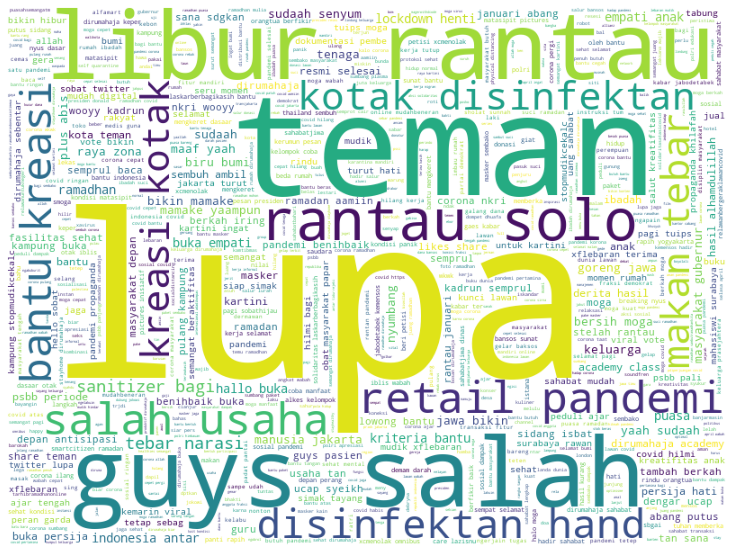

In [11]:
# WordCloud kata dengan bobot terbesar Positif
w = WordCloud(
    width=800,
    height=600,
    mode="RGBA",
    stopwords=stop_words,
    background_color="white",
    max_words=5000,
).fit_words(top_positif)
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(w)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Negatif**

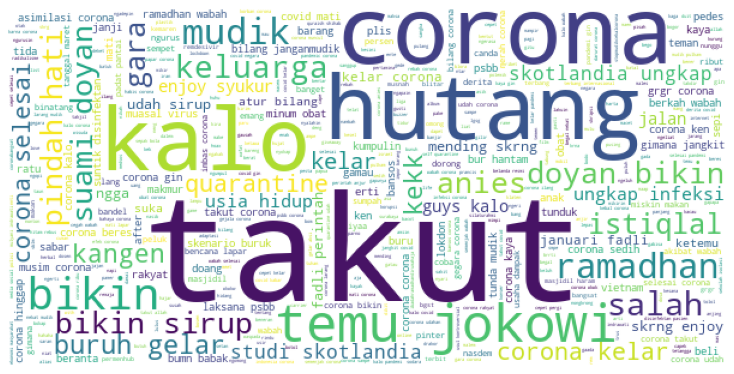

In [12]:
# WordCloud kata dengan bobot terbesar Negatif
w = WordCloud(
    width=600,
    height=300,
    mode="RGBA",
    stopwords=stop_words,
    background_color="white",
    max_words=5000,
).fit_words(top_negatif)
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(w)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()